<a href="https://colab.research.google.com/github/Gaurangg1404/learning-AI-ML/blob/main/transfer_learning_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Jun 25 13:56:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-25 13:56:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-25 13:56:24 (83.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test"

--2024-06-25 13:56:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.207, 142.250.153.207, 142.250.145.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  38.7MB/s    in 42s     

2024-06-25 13:57:11 (37.1 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bruschetta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_fries'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/waffles'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/onion_rings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_roll_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sashimi'.
There are 0 directories and 75 images in '101_fo

In [6]:
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [7]:
checkpoint_path="101_classes_10_percent_data_model_checkpoint"
checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only=True,
                                                        monitor="val_accuracy",
                                                        save_best_only=True)


In [8]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),

], name="data_augmentation")

In [9]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224,224,3),name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)


16705208/16705208 [==============================] - 1s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [12]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 169s 662ms/step - loss: 3.3670 - accuracy: 0.2726 - val_loss: 2.4933 - val_accuracy: 0.4590
Epoch 2/5
237/237 [==============================] - 105s 438ms/step - loss: 2.2036 - accuracy: 0.4991 - val_loss: 2.0053 - val_accuracy: 0.5283
Epoch 3/5
237/237 [==============================] - 95s 399ms/step - loss: 1.8242 - accuracy: 0.5657 - val_loss: 1.8870 - val_accuracy: 0.5331
Epoch 4/5
237/237 [==============================] - 81s 338ms/step - loss: 1.5983 - accuracy: 0.6084 - val_loss: 1.7952 - val_accuracy: 0.5434
Epoch 5/5
237/237 [==============================] - 73s 306ms/step - loss: 1.4522 - accuracy: 0.6409 - val_loss: 1.7507 - val_accuracy: 0.5495


In [13]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 62s 79ms/step - loss: 1.5756 - accuracy: 0.5879


[1.5756264925003052, 0.5879207849502563]

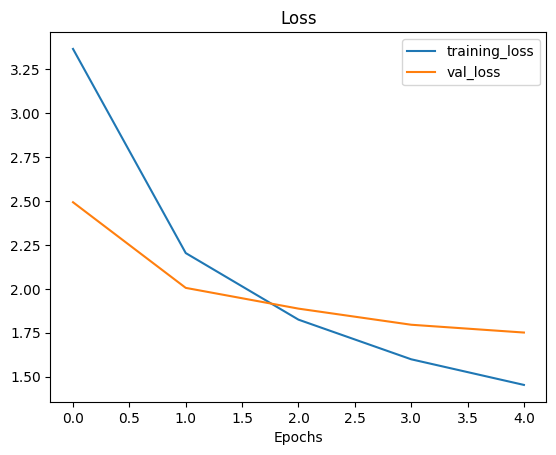

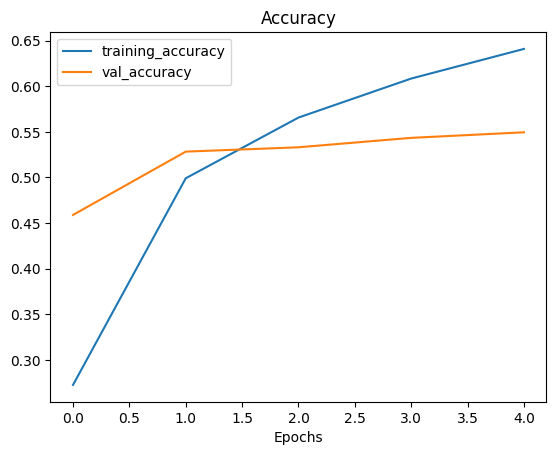

In [14]:
plot_loss_curves(history_all_classes_10_percent)

In [15]:

base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable=False


In [19]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])


In [20]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [21]:
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
fine_tune_epochs=10

history_all_classes_10_percent_fine_tune= model.fit(train_data_all_10_percent,
                                                    epochs=fine_tune_epochs,
                                                    validation_data=test_data,
                                                    validation_steps=int(0.15*len(test_data)),
                                                    initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 82s 309ms/step - loss: 1.5008 - accuracy: 0.5970 - val_loss: 1.8270 - val_accuracy: 0.5207
Epoch 6/10
237/237 [==============================] - 65s 274ms/step - loss: 1.0831 - accuracy: 0.7044 - val_loss: 1.7868 - val_accuracy: 0.5456
Epoch 7/10
237/237 [==============================] - 61s 258ms/step - loss: 0.8378 - accuracy: 0.7646 - val_loss: 1.7721 - val_accuracy: 0.5617
Epoch 8/10
237/237 [==============================] - 60s 250ms/step - loss: 0.6448 - accuracy: 0.8141 - val_loss: 1.8384 - val_accuracy: 0.5662
Epoch 9/10
237/237 [==============================] - ETA: 0s - loss: 0.5325 - accuracy: 0.8442

In [23]:
all_classes_10_percent_fine_tune_results =  model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 59s 75ms/step - loss: 1.8167 - accuracy: 0.5752


[1.8167332410812378, 0.5751683115959167]

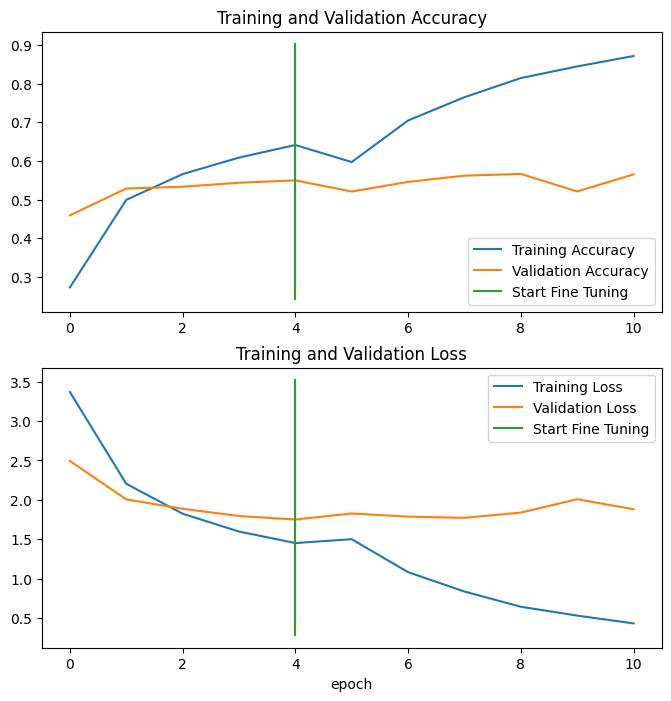

In [25]:
compare_historys(original_history=history_all_classes_10_percent,
                new_history=history_all_classes_10_percent_fine_tune,
                initial_epochs=5)

In [26]:
model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_big_dog_model")

In [27]:
loaded_model=tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_big_dog_model")

In [28]:
loaded_model_results=loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 64s 78ms/step - loss: 1.8167 - accuracy: 0.5752


[1.8167332410812378, 0.5751683115959167]

In [29]:
all_classes_10_percent_fine_tune_results

[1.8167332410812378, 0.5751683115959167]

In [30]:
import tensorflow as tf
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-06-25 15:11:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.207, 173.194.69.207, 173.194.79.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  20.8MB/s    in 2.1s    

2024-06-25 15:11:59 (20.8 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [31]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [32]:
result_downloaded_model=model.evaluate(test_data)
result_downloaded_model

790/790 [==============================] - 59s 74ms/step - loss: 1.8167 - accuracy: 0.5752


[1.8167332410812378, 0.5751683115959167]

In [33]:
preds_probs = model.predict(test_data, verbose=1)


790/790 [==============================] - 68s 84ms/step


In [34]:
len(test_data)

790

In [36]:
preds_probs[0],len(preds_probs[0]),sum(preds_probs[0])

(array([4.47601557e-01, 1.77624247e-06, 1.40609611e-02, 5.07556237e-08,
        3.84677520e-07, 4.14506651e-08, 1.44876365e-04, 2.13587805e-06,
        4.06968500e-03, 6.36930918e-06, 3.64795596e-07, 3.42390149e-06,
        1.12637172e-04, 1.07744356e-07, 1.34838538e-05, 1.83518697e-03,
        1.59482560e-08, 3.68409645e-04, 9.73048271e-04, 3.17219474e-06,
        1.36031983e-02, 2.69580369e-06, 4.47939465e-06, 4.77820795e-05,
        3.02469209e-02, 7.22494500e-04, 3.63762119e-05, 6.57873170e-05,
        6.80608302e-02, 4.98903799e-04, 7.48764393e-08, 3.12162883e-04,
        2.83822301e-04, 1.38939356e-07, 8.24621134e-03, 1.06689658e-05,
        8.13142378e-07, 5.76510283e-05, 3.01771070e-04, 2.87935763e-05,
        2.88420852e-04, 8.47413670e-04, 7.31674299e-05, 1.07043877e-06,
        4.98760637e-05, 6.51355947e-08, 1.95544213e-03, 5.93833574e-05,
        4.19694629e-07, 2.88075022e-02, 7.07437448e-06, 7.01112924e-07,
        2.22922400e-01, 3.92184826e-03, 8.95053972e-07, 1.237294

In [37]:
print(f"Number of prediction probabilities for sample0:{len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like: \n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0:{preds_probs[0].argmax()} ")

Number of prediction probabilities for sample0:101
What prediction probability sample 0 looks like: 
 [4.47601557e-01 1.77624247e-06 1.40609611e-02 5.07556237e-08
 3.84677520e-07 4.14506651e-08 1.44876365e-04 2.13587805e-06
 4.06968500e-03 6.36930918e-06 3.64795596e-07 3.42390149e-06
 1.12637172e-04 1.07744356e-07 1.34838538e-05 1.83518697e-03
 1.59482560e-08 3.68409645e-04 9.73048271e-04 3.17219474e-06
 1.36031983e-02 2.69580369e-06 4.47939465e-06 4.77820795e-05
 3.02469209e-02 7.22494500e-04 3.63762119e-05 6.57873170e-05
 6.80608302e-02 4.98903799e-04 7.48764393e-08 3.12162883e-04
 2.83822301e-04 1.38939356e-07 8.24621134e-03 1.06689658e-05
 8.13142378e-07 5.76510283e-05 3.01771070e-04 2.87935763e-05
 2.88420852e-04 8.47413670e-04 7.31674299e-05 1.07043877e-06
 4.98760637e-05 6.51355947e-08 1.95544213e-03 5.93833574e-05
 4.19694629e-07 2.88075022e-02 7.07437448e-06 7.01112924e-07
 2.22922400e-01 3.92184826e-03 8.95053972e-07 1.23729420e-04
 2.61903368e-02 1.43640395e-03 4.05072096e-0